In [1]:
import pandas as pd
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MIT\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv("../../raw_analyst_ratings.csv")
df.dtypes

Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object

In [50]:
df.sample()

,Unnamed: 0,headline,url,publisher,date,stock,word_count
698711,702264,Option Alert: JD Sep16 31.0 Calls Sweep: 800 @...,https://www.benzinga.com/markets/options/16/07...,Charles Gross,2016-07-26 00:00:00,JD,20


In [4]:
df.isnull().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

**Descriptive Statistics**

In [5]:
def count_words(column):
    return len(column.split())

df['word_count'] = df['headline'].apply(count_words)

In [6]:
df['word_count'].describe().round(2)

count    1407328.00
mean          11.42
std            6.35
min            1.00
25%            7.00
50%           10.00
75%           13.00
max           77.00
Name: word_count, dtype: float64

The average number of words in the headlines for the given dataset is around 11 words. From the summary above, it is also noticeable that there is a headline consisting of a single word to the minimum and there is a headline containing up to 77 words to the maximum.

In [7]:
articles_per_pub = df.groupby('publisher')['headline'].count().reset_index()

In [51]:
sorted_articlesPerPub = articles_per_pub.sort_values(by='headline', ascending=False)
sorted_articlesPerPub.head(10)

,publisher,headline
686,Paul Quintaro,228373
532,Lisa Levin,186979
96,Benzinga Newsdesk,150484
169,Charles Gross,96732
622,Monica Gerson,82380
275,Eddie Staley,57254
353,Hal Lindon,49047
270,ETF Professor,28489
478,Juan Lopez,28438
98,Benzinga Staff,28114


These are the top 10 most active publishers based on the number of articles they publish.

In [9]:
articles_per_date = df.groupby('date')['headline'].count().reset_index()

In [10]:
articles_per_date.sample(5)

,date,headline
15985,2017-10-09 00:00:00,368
30713,2020-04-23 16:11:02-04:00,1
20244,2019-01-08 13:46:52-04:00,1
36560,2020-05-22 06:01:04-04:00,1
5921,2015-03-12 04:37:20-04:00,2


In [11]:
date_indexed_df = articles_per_date.copy()
date_indexed_df["date"] = pd.to_datetime(date_indexed_df["date"],format='ISO8601',utc=True)

date_indexed_df.set_index("date",inplace=True)
monthly_data = date_indexed_df.resample('ME').sum()
sorted_articlesPerDate = monthly_data.sort_values(by='headline', ascending=False)
sorted_articlesPerDate.head(10)

,headline
date,
2020-03-31 00:00:00+00:00,24995
2020-04-30 00:00:00+00:00,20757
2020-02-29 00:00:00+00:00,18878
2020-05-31 00:00:00+00:00,17992
2018-08-31 00:00:00+00:00,16681
2019-10-31 00:00:00+00:00,16560
2019-08-31 00:00:00+00:00,16462
2018-10-31 00:00:00+00:00,16294
2020-01-31 00:00:00+00:00,16145


The top 2 periods in which news related to the stock market was frequent are March and April of 2020. This may be due to the crash that followed instability due to the COVID-19 pandemic, which spanned the period from February 20 to April 7.

**Text Analysis**

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer ()

# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores (headline) for headline in df['headline'].values ]
scores_df = pd.DataFrame(scores)

# Join the DataFrames
scored_news = pd.concat([df, scores_df], axis = 1)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date,format='ISO8601',utc=True)
scored_news.sample()

,Unnamed: 0,headline,url,publisher,date,stock,word_count,neg,neu,pos,compound
132397,133382,Alibaba Investment Arm Will Enter The Steel Tr...,https://www.benzinga.com/trading-ideas/long-id...,Jayson Derrick,2015-12-03 04:00:00+00:00,BABA,9,0.0,1.0,0.0,0.0


In [22]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK resources (run only once)
nltk.download('punkt')
nltk.download('stopwords')

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))
keywords = []
for headline in df['headline']:
    words = word_tokenize(headline.lower())  # Tokenize and convert to lowercase
    words = [word for word in words if word.isalnum() and word not in stop_words]  # Remove stopwords and non-alphanumeric characters
    keywords.extend(words)

# Frequency analysis to identify common keywords
keyword_freq = Counter(keywords)
common_keywords = keyword_freq.most_common(30)  # Get the top 5 most common keywords

# Display common keywords
print("Common Keywords:")
for keyword, frequency in common_keywords:
    print(f"{keyword}: {frequency} times",end=' | ')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Common Keywords:
stocks: 161702 times | vs: 138835 times | eps: 128801 times | est: 122289 times | shares: 114140 times | reports: 108688 times | update: 91645 times | market: 91080 times | earnings: 87183 times | sales: 79528 times | top: 78493 times | benzinga: 74466 times | pt: 73059 times | announces: 66531 times | price: 64217 times | buy: 63928 times | downgrades: 61942 times | trading: 61146 times | raises: 57793 times | upgrades: 56802 times | target: 54669 times | maintains: 52960 times | higher: 48150 times | new: 47875 times | session: 45333 times | says: 43123 times | moving: 42248 times | q4: 40448 times | stock: 39334 times | q1: 38433 times | 

**Time series analysis**

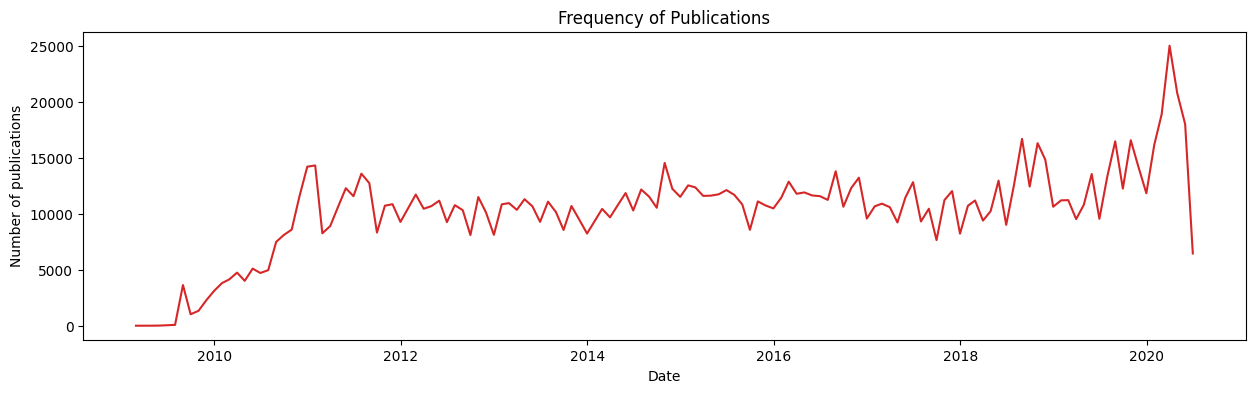

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

time_indexed_df = df.loc[:, ['date', 'headline']]
time_indexed_df["date"] = pd.to_datetime(time_indexed_df["date"],format='ISO8601',utc=True)
time_indexed_df.set_index('date',inplace=True)
mon_data = time_indexed_df.resample('ME').count()

def plot_df(df, x ,y, title="", xlabel="Date", ylabel="Number of publications", dpi=100):
    plt.figure(figsize=(15,4),dpi=dpi)
    plt.plot(x,y,color="tab:red")
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(monthly_data,x=monthly_data.index,y=monthly_data["headline"],title = "Frequency of Publications")

Publication frequency is constant in the range of 8000 to 1600 publications between 2011 and the start of 2020. However. there are two noticeable features outside the mentioned period. The first one is an upward or positive trend visible for a short-term spanning 2 years, from 2010 to 2012. The second one is a spike in publications which is seen at the start of the 2020.

**Publisher Analysis**

In [47]:
publisher_df = scored_news.loc[:, ['publisher', 'neg', 'neu', 'pos']]
publisher_score_df = publisher_df.groupby('publisher')[['neg','neu','pos']].mean().reset_index()
publisher_score_df.sample(10)

,publisher,neg,neu,pos
56,Ankitha Taranath,0.150000,0.850000,0.000000
540,LouisDematteis,0.304000,0.696000,0.000000
241,David Pinsen,0.094558,0.850581,0.054860
205,Courtney Myers,0.033636,0.923000,0.043364
163,Carl Cachia,0.000000,1.000000,0.000000
624,Mortimer Duke,0.114800,0.737700,0.147400
123,Bob Lang,0.016444,0.919833,0.063722
135,Brent Douglas,0.000000,0.799667,0.200333
83,BehindWallStreet,0.060056,0.806889,0.133167
991,luke@benzinga.com,0.053128,0.873712,0.073146


In [48]:
#concatenating 
type_of_news = pd.concat([publisher_score_df,sorted_articlesPerPub],axis=1)

#remove duplicate column(publisher) after concatenating the two data frames
type_of_news = type_of_news.loc[:, ~type_of_news.columns.duplicated()]

type_of_news = type_of_news.sort_values(by='headline',ascending=False)
type_of_news.head(10)

,publisher,neg,neu,pos,headline
686,Paul Quintaro,0.026729,0.900862,0.072408,228373
532,Lisa Levin,0.056001,0.869918,0.074084,186979
96,Benzinga Newsdesk,0.057803,0.866498,0.075694,150484
169,Charles Gross,0.033247,0.876613,0.090141,96732
622,Monica Gerson,0.041197,0.840466,0.118347,82380
275,Eddie Staley,0.032405,0.886153,0.081440,57254
353,Hal Lindon,0.024336,0.897421,0.078241,49047
270,ETF Professor,0.040122,0.880974,0.078904,28489
478,Juan Lopez,0.055644,0.899491,0.044858,28438
98,Benzinga Staff,0.023909,0.891427,0.084663,28114
